In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import glob
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

/opt/conda/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


## Dataset Prepare

In [2]:
def get_ead_dicts(img_dir):    
    images_path = os.path.join(img_dir, '*.jpg')
    images = glob.glob(images_path)
    
    dataset_dicts = []
    
    for idx, image_path in enumerate(images):
        text_path= image_path.replace(".jpg", ".txt")
        
        record = {}

        height, width = cv2.imread(image_path).shape[:2]
        
        record["file_name"] = image_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width        
        
        with open(text_path) as f:
            contents = f.readlines()
        
        objs = []
        for content in contents:
            information = content.split(' ')
            
            obj = {
                "bbox": [(float(information[1]) - float(information[3]) / 2)*width, 
                         (float(information[2]) - float(information[4]) / 2)*height, 
                         (float(information[1]) + float(information[3]) / 2)*width, 
                         (float(information[2]) + float(information[4]) / 2)*height],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": int(information[0])
            }
            objs.append(obj)
                        
        record["annotations"] = objs
        dataset_dicts.append(record)                        
    return dataset_dicts

In [3]:
from detectron2.data import DatasetCatalog, MetadataCatalog

DatasetCatalog.clear()

train_path = r'/home/ws2080/Desktop/data/training/train_augmented/'
validation_path = r'/home/ws2080/Desktop/data/training/validation/'

d= 'train'
DatasetCatalog.register("ead_train_1", lambda d=d: get_ead_dicts(train_path))
MetadataCatalog.get("ead_train_1").set(thing_classes=["specularity", "saturation", "artifact", "blur", "contrast", "bubbles", "instrument", "blood"])

d= 'validation'
DatasetCatalog.register("ead_validation_1", lambda d=d: get_ead_dicts(validation_path))
MetadataCatalog.get("ead_validation_1").set(thing_classes=["specularity", "saturation", "artifact", "blur", "contrast", "bubbles", "instrument", "blood"])

Metadata(name='ead_validation_1', thing_classes=['specularity', 'saturation', 'artifact', 'blur', 'contrast', 'bubbles', 'instrument', 'blood'])

/home/ws2080/Desktop/data/training/train_augmented/EAD2020_frameOnly_01675_0_not_flipped.jpg


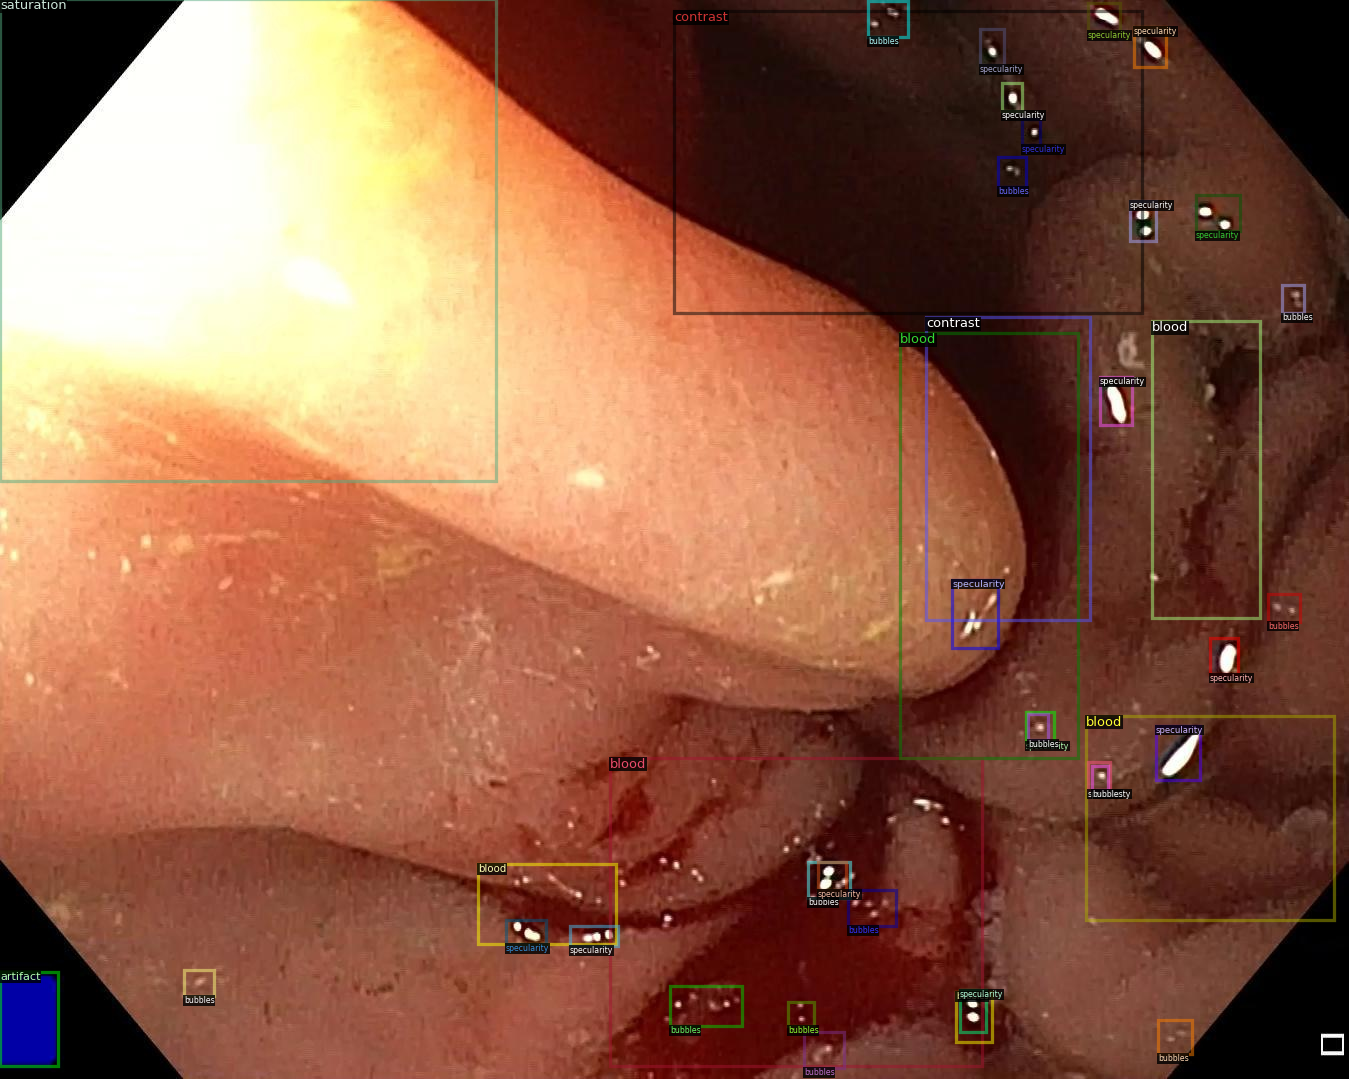

In [4]:
ead_metadata = MetadataCatalog.get("ead_train_1")
dataset_dicts = get_ead_dicts(train_path)

for d in random.sample(dataset_dicts, 1):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ead_metadata)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Training

In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("ead_train_1",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 4    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  
cfg.MODEL.MASK_ON = False

#Gorkem
cfg.INPUT.MIN_SIZE_TRAIN = (512,)
cfg.INPUT.MAX_SIZE_TRAIN = 512
cfg.INPUT.MIN_SIZE_TEST = 512
cfg.INPUT.MAX_SIZE_TEST = 512

cfg.MODEL.ANCHOR_GENERATOR.SIZES= [[15], [25], [80], [256], [450]]
cfg.SOLVER.BASE_LR = 0.1  
cfg.SOLVER.STEPS = (150000, 190000)
cfg.SOLVER.CHECKPOINT_PERIOD = 10000
cfg.SOLVER.MAX_ITER = 200000

config_yaml = cfg.dump()
text_file = open("output/config.yaml", "w")
text_file.write(config_yaml)
text_file.close()

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


[02/29 13:53:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[02/29 13:54:38 d2.data.build]: Removed 0 images with no usable annotations. 17848 images left.
[02/29 13:54:38 d2.data.build]: Distribution of instances among all 8 categories:
|  category   | #instances   |  category  | #instances   |  category  | #instances   |
|:-----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| specularity | 83680        | saturation | 10000        |  artifact  | 61800        |
|    blur     | 5224         |  contrast  | 13136        |  bubbles   | 37784        |
| instrument  | 4344         |   blood    | 3800         |            |              |
|    total    | 219768       |            |              |            |              |
[02/29 13:54:38 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[02/29 13:54:38 d2.data.build]: Using training sampler TrainingSampler


model_final_480dd8.pkl: 288MB [00:31, 9.25MB/s]                               
'roi_heads.box_predictor.0.cls_score.weight' has shape (81, 1024) in the checkpoint but (9, 1024) in the model! Skipped.
'roi_heads.box_predictor.0.cls_score.bias' has shape (81,) in the checkpoint but (9,) in the model! Skipped.
'roi_heads.box_predictor.1.cls_score.weight' has shape (81, 1024) in the checkpoint but (9, 1024) in the model! Skipped.
'roi_heads.box_predictor.1.cls_score.bias' has shape (81,) in the checkpoint but (9,) in the model! Skipped.
'roi_heads.box_predictor.2.cls_score.weight' has shape (81, 1024) in the checkpoint but (9, 1024) in the model! Skipped.
'roi_heads.box_predictor.2.cls_score.bias' has shape (81,) in the checkpoint but (9,) in the model! Skipped.


[02/29 13:55:10 d2.engine.train_loop]: Starting training from iteration 0
[02/29 13:55:15 d2.utils.events]: eta: 13:27:49  iter: 19  total_loss: 5.466  loss_cls_stage0: 1.086  loss_box_reg_stage0: 0.601  loss_cls_stage1: 1.055  loss_box_reg_stage1: 0.697  loss_cls_stage2: 0.830  loss_box_reg_stage2: 0.477  loss_rpn_cls: 0.286  loss_rpn_loc: 0.146  time: 0.2428  data_time: 0.0282  lr: 0.001998  max_mem: 1912M
[02/29 13:55:20 d2.utils.events]: eta: 13:29:12  iter: 39  total_loss: 4.647  loss_cls_stage0: 0.857  loss_box_reg_stage0: 0.673  loss_cls_stage1: 0.700  loss_box_reg_stage1: 0.862  loss_cls_stage2: 0.539  loss_box_reg_stage2: 0.622  loss_rpn_cls: 0.171  loss_rpn_loc: 0.189  time: 0.2414  data_time: 0.0223  lr: 0.003996  max_mem: 1912M
[02/29 13:55:25 d2.utils.events]: eta: 13:27:25  iter: 59  total_loss: 4.239  loss_cls_stage0: 0.674  loss_box_reg_stage0: 0.568  loss_cls_stage1: 0.632  loss_box_reg_stage1: 0.808  loss_cls_stage2: 0.511  loss_box_reg_stage2: 0.676  loss_rpn_cls: 0.

[02/29 13:57:12 d2.utils.events]: eta: 13:23:06  iter: 499  total_loss: 3.780  loss_cls_stage0: 0.541  loss_box_reg_stage0: 0.598  loss_cls_stage1: 0.441  loss_box_reg_stage1: 0.799  loss_cls_stage2: 0.343  loss_box_reg_stage2: 0.611  loss_rpn_cls: 0.145  loss_rpn_loc: 0.255  time: 0.2397  data_time: 0.0228  lr: 0.049950  max_mem: 1913M
[02/29 13:57:17 d2.utils.events]: eta: 13:23:03  iter: 519  total_loss: 3.745  loss_cls_stage0: 0.535  loss_box_reg_stage0: 0.683  loss_cls_stage1: 0.441  loss_box_reg_stage1: 0.783  loss_cls_stage2: 0.334  loss_box_reg_stage2: 0.584  loss_rpn_cls: 0.180  loss_rpn_loc: 0.223  time: 0.2398  data_time: 0.0177  lr: 0.051948  max_mem: 1913M
ERROR [02/29 13:57:18 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/detectron2/engine/train_loop.py", line 132, in train
    self.run_step()
  File "/opt/conda/lib/python3.7/site-packages/detectron2/engine/train_loop.py", line 214, in r

## Inference

In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("ead_validation_1", )
predictor = DefaultPredictor(cfg)

AssertionError: Checkpoint ./output/model_final.pth not found!

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_ead_dicts(validation_path)
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=ead_metadata
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("ead_validation_1", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "ead_validation_1")
inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
import torch
torch.cuda.empty_cache()